# MNIST classification with Probabilisitc Neural Network

### Import Library

In [1]:
# Pytorch Library
import torch
from torch import nn, optim
import torchvision.utils as utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
torch.manual_seed(777)  # reproducibility

### Prepare MNIST dataset and dataloader

In [2]:
data = dset.MNIST("./", train=True, transform=transforms.ToTensor(), download=True)
print('number of data', len(data))

Processing...
Done!
number of data 60000


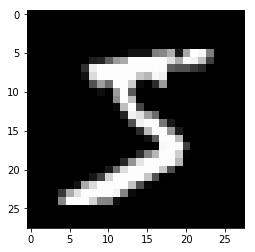

In [3]:
img, label = data[0]
#plt.figure(figsize=[6,6])
plt.imshow(img.squeeze().numpy(), cmap='gray')
plt.show()

In [4]:
batch_size = 100
data_loader = torch.utils.data.DataLoader(data,batch_size=batch_size, shuffle=True,num_workers=2)

## 1. Conventional Fully Connected (FC) Neural Network 

#### Define Model

In [5]:
input_size = 28*28
output_size = 10
hid1_size = 256
hid2_size = 128

In [6]:
class FC(nn.Module):
    def __init__(self):
        super(FC, self).__init__()
        self.fc1 = nn.Linear(input_size, hid1_size)
        self.fc2 = nn.Linear(hid1_size, hid2_size)
        self.logits = nn.Linear(hid2_size, output_size)
    def forward(self, input): # no activation function
        output = self.fc1(input)
        output = self.fc2(output)
        output = self.logits(output)
        return output
net_fc = FC()
net_fc.cuda()

FC(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (logits): Linear(in_features=128, out_features=10, bias=True)
)

#### Train Model

In [14]:
# Build a convinience function for reuse
def train(net):
    acc_log = []
    loss_log = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    max_epoch = 30
    accuracy = 0
    output_frequency = 1
    
    for epoch in range(max_epoch):
        for i, (images, labels) in enumerate(data_loader):

            optimizer.zero_grad()             # Zero Gradient Container

            X = images.view(-1, input_size).cuda()
            Y = labels.cuda()        # label is not one-hot encoded
            logits = net(X)           # Forward Propagation
            loss = criterion(logits, Y) # compute cost

            loss.backward()                   # compute gradient
            optimizer.step()                  # gradient update
            
            loss_log.append(loss.item())
            _, idx = logits.cpu().max(dim=1)
            accuracy += torch.sum(idx.view(batch_size) == labels.cpu()).item() / batch_size

        if epoch%output_frequency == 0:
            accuracy /= 60000/batch_size
            acc_log.append(accuracy)
            print("epoch {}, loss {}, accuracy {:6.4f}".format(epoch, loss.item(), accuracy))
            accuracy = 0
    return acc_log, loss_log

In [15]:
acc_fc, loss_fc = train(net_fc)

epoch 0, loss 0.42216822504997253, accuracy 0.9257
epoch 1, loss 0.44471436738967896, accuracy 0.9245
epoch 2, loss 0.2154730260372162, accuracy 0.9255
epoch 3, loss 0.21554253995418549, accuracy 0.9266
epoch 4, loss 0.22164778411388397, accuracy 0.9270
epoch 5, loss 0.3942492604255676, accuracy 0.9263
epoch 6, loss 0.15498343110084534, accuracy 0.9268
epoch 7, loss 0.30223655700683594, accuracy 0.9284
epoch 8, loss 0.30549803376197815, accuracy 0.9284
epoch 9, loss 0.3879879117012024, accuracy 0.9283
epoch 10, loss 0.1677778661251068, accuracy 0.9298
epoch 11, loss 0.1511961966753006, accuracy 0.9281
epoch 12, loss 0.234945148229599, accuracy 0.9283
epoch 13, loss 0.3012317717075348, accuracy 0.9297
epoch 14, loss 0.2286638617515564, accuracy 0.9295
epoch 15, loss 0.3072064518928528, accuracy 0.9292
epoch 16, loss 0.1850736290216446, accuracy 0.9296
epoch 17, loss 0.18752487003803253, accuracy 0.9293
epoch 18, loss 0.16514647006988525, accuracy 0.9300
epoch 19, loss 0.1671440154314041

## 2. Neural Network with Gaussian Latent Layer
Model NN(x) :

- $ a \sim P(a | \mu(x),\sigma(x))$  (x is image input)

- $ y = fc2(a) $                     (y is label)

Model NN(x) (reparameterization):

- $ a=\mu(x) + \sigma(x)*\epsilon$  where $\epsilon \sim Gaussian(0,1)$ (reparameterization)

- $ y = fc2(a) $                     (y is label)

Loss: 

- $CrossEntropy(y,fc2(a)) + KL(Gaussian(0,1) || Gaussian(\mu(x),\sigma(x)))$

In [17]:
class GaussianNN(nn.Module):
    def __init__(self):
        super(GaussianNN, self).__init__()
        self.fc1_mu = nn.Linear(input_size, hid1_size)
        self.fc1_sigma = nn.Linear(input_size, hid1_size)
        self.fc2 = nn.Linear(hid1_size, hid2_size)
        self.logits = nn.Linear(hid2_size, output_size)
        
    def forward(self, input): # no activation function
        mu = self.fc1_mu(input)
        sigma = self.fc1_sigma(input)
        noise = torch.randn(mu.size()).cuda()
        noise = mu+sigma*noise
        output = self.fc2(noise)
        output = self.logits(output)
        return output, mu, sigma, noise

net_gaussian = GaussianNN()
net_gaussian.cuda()

GaussianNN(
  (fc1_mu): Linear(in_features=784, out_features=256, bias=True)
  (fc1_sigma): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (logits): Linear(in_features=128, out_features=10, bias=True)
)

### Train Model

In [20]:
# Build a convinience function for reuse
def train(net):
    acc_log = []
    loss_log = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=0.001)
    max_epoch = 30
    accuracy = 0
    output_frequency = 1
    for epoch in range(max_epoch):
        for i, (images, labels) in enumerate(data_loader):
            optimizer.zero_grad()             # Zero Gradient Container

            X = images.view(-1, input_size).cuda()
            Y = labels.cuda()                  # label is not one-hot encoded
            logits, mu, sigma, noise = net(X)  # Forward Propagation
            loss = criterion(logits, Y)        # compute cost
            loss += torch.mean(mu**2 + torch.mean(sigma**2) - torch.log(sigma**2+1e-8) - 1) # latent loss

            loss.backward()                   # compute gradient
            optimizer.step()                  # gradient update
         
            loss_log.append(loss.item())
            _, idx = logits.cpu().max(dim=1)
            accuracy += torch.sum(idx.view(batch_size) == labels.cpu()).item() / batch_size

        if epoch%output_frequency == 0:
            accuracy /= 60000/batch_size
            acc_log.append(accuracy)
            print("epoch {}, loss {}, accuracy {:6.4f}".format(epoch, loss.item(), accuracy))
            accuracy = 0
    return acc_log, loss_log


In [21]:
acc_gaussian, loss_gaussian = train(net_gaussian)

epoch 0, loss 0.81312096118927, accuracy 0.8393
epoch 1, loss 0.7378884553909302, accuracy 0.8626
epoch 2, loss 0.7240248918533325, accuracy 0.8681
epoch 3, loss 0.7296925783157349, accuracy 0.8754
epoch 4, loss 0.593469500541687, accuracy 0.8783
epoch 5, loss 0.5158708095550537, accuracy 0.8838
epoch 6, loss 0.6605126261711121, accuracy 0.8863
epoch 7, loss 0.5710251927375793, accuracy 0.8903
epoch 8, loss 0.5542190074920654, accuracy 0.8917
epoch 9, loss 0.638914942741394, accuracy 0.8942
epoch 10, loss 0.4397118091583252, accuracy 0.8978
epoch 11, loss 0.5654210448265076, accuracy 0.8976
epoch 12, loss 0.43102264404296875, accuracy 0.8966
epoch 13, loss 0.4512672424316406, accuracy 0.8992
epoch 14, loss 0.5550481677055359, accuracy 0.8981
epoch 15, loss 0.49977564811706543, accuracy 0.8998
epoch 16, loss 0.5924245715141296, accuracy 0.9008
epoch 17, loss 0.5135105848312378, accuracy 0.9009
epoch 18, loss 0.610207200050354, accuracy 0.9024
epoch 19, loss 0.44529086351394653, accuracy

### 3. Zero-centered Uniform Latent Net
Model NN(x) :

- $ a \sim P(a | \mu(x),\sigma(x))$  (x is image input)

- $ y = fc2(a) $                     (y is label)

Model NN(x) (reparameterization):

- $ a=\mu(x) + \sigma(x)*\epsilon$  where $\epsilon \sim Uniform(-0.5,0.5)$ (reparameterization)

- $ y = fc2(a) $                     (y is label)

Loss: 

- $CrossEntropy(y,fc2(a)) + KL(Gaussian(0,1) || Gaussian(\mu(x),\sigma(x)))$

In [22]:
class UniformNN(nn.Module):
    def __init__(self):
        super(UniformNN, self).__init__()
        self.fc1_mu = nn.Linear(input_size, hid1_size)
        self.fc1_sigma = nn.Linear(input_size, hid1_size)
        self.fc2 = nn.Linear(hid1_size, hid2_size)
        self.logits = nn.Linear(hid2_size, output_size)
        
    def forward(self, input): # no activation function
        mu = self.fc1_mu(input)
        sigma = self.fc1_sigma(input)
        noise = torch.rand(mu.size()).cuda()-0.5
        noise = mu+sigma*noise
        output = self.fc2(noise)
        output = self.logits(output)
        return output, mu, sigma, noise
    
net_uniform = UniformNN()
net_uniform.cuda()

UniformNN(
  (fc1_mu): Linear(in_features=784, out_features=256, bias=True)
  (fc1_sigma): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=128, bias=True)
  (logits): Linear(in_features=128, out_features=10, bias=True)
)

In [23]:
acc_uniform, loss_uniform = train(net_uniform)

epoch 0, loss 0.6309908628463745, accuracy 0.8792
epoch 1, loss 0.46502286195755005, accuracy 0.8968
epoch 2, loss 0.45638054609298706, accuracy 0.8990
epoch 3, loss 0.4982227087020874, accuracy 0.9008
epoch 4, loss 0.5881772637367249, accuracy 0.9024
epoch 5, loss 0.4686458110809326, accuracy 0.9024
epoch 6, loss 0.22975566983222961, accuracy 0.9038
epoch 7, loss 0.41796714067459106, accuracy 0.9049
epoch 8, loss 0.4512791633605957, accuracy 0.9057
epoch 9, loss 0.3911142945289612, accuracy 0.9070
epoch 10, loss 0.4532027840614319, accuracy 0.9076
epoch 11, loss 0.4592922627925873, accuracy 0.9080
epoch 12, loss 0.5921841859817505, accuracy 0.9081
epoch 13, loss 0.2966078519821167, accuracy 0.9096
epoch 14, loss 0.5257330536842346, accuracy 0.9108
epoch 15, loss 0.4086162745952606, accuracy 0.9111
epoch 16, loss 0.42832550406455994, accuracy 0.9111
epoch 17, loss 0.3168146312236786, accuracy 0.9115
epoch 18, loss 0.4121221601963043, accuracy 0.9123
epoch 19, loss 0.5203074216842651, a

### Compare training loss and accuracy of 1, 2 and 3

Text(0,0.5,'loss')

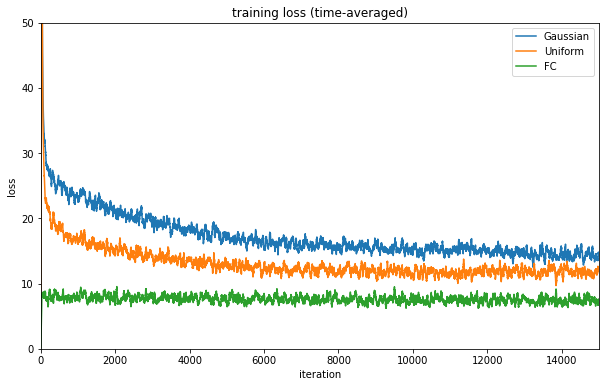

In [24]:
plt.figure(figsize=[10,6])
for loss in [loss_gaussian, loss_uniform, loss_fc]:
    plt.plot(np.convolve(loss, np.ones(30)))
plt.xlim([0,15000])
plt.ylim([0,50])
plt.legend(['Gaussian','Uniform','FC'])
plt.title('training loss (time-averaged)')
plt.xlabel('iteration')
plt.ylabel('loss')

Text(0,0.5,'accuracy')

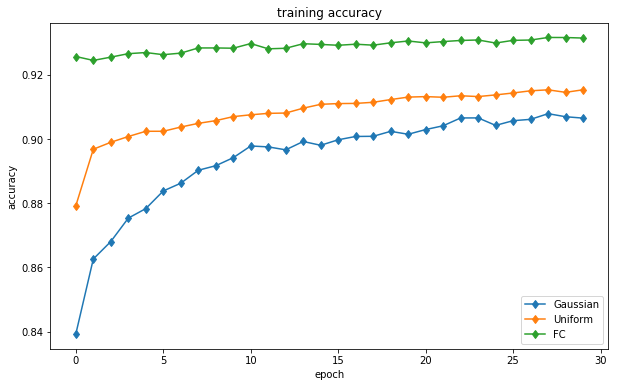

In [25]:
plt.figure(figsize=[10,6])
for acc in [acc_gaussian, acc_uniform, acc_fc]:
    plt.plot(range(30), acc,'-d')

plt.legend(['Gaussian','Uniform','FC'])
plt.title('training accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')